In [1]:
#montar drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Crear Generadores de Datos y Entrenar el Modelo

#Modelo CNN

Entrenamiento del Modelo CNN

#Resumen ejecutivo: Arquitectura, ventajas y desventajas del modelo


Arquitectura:

El código define un modelo de Red Neuronal Convolucional (CNN) personalizada para la clasificación de imágenes de neumonía.

La red consta de capas convolucionales alternas con Batch Normalization y MaxPooling para extraer características de las imágenes.

Utiliza GlobalAveragePooling2D en lugar de Flatten para reducir la dimensionalidad de las características extraídas.

Incluye capas densas totalmente conectadas con activación ReLU y regularización L2 para la clasificación final.

Se compila con la función de pérdida 'binary_crossentropy' y el optimizador RMSprop con una tasa de aprendizaje baja (1e-5) para un entrenamiento más estable.


Ventajas:

La arquitectura CNN es adecuada para tareas de clasificación de imágenes debido a su capacidad para capturar patrones espaciales en los datos.

El uso de Batch Normalization estabiliza el entrenamiento del modelo y acelera la convergencia.

La regularización L2 ayuda a prevenir el sobreajuste y mejora la generalización del modelo.

El aumento de datos con técnicas como rotación y cambio de escala amplía el conjunto de datos de entrenamiento artificialmente, lo que ayuda a mejorar la robustez del modelo.

Se guardan los mejores pesos del modelo durante el entrenamiento para garantizar el mejor rendimiento en el conjunto de validation.

El entrenamiento temprano detiene el entrenamiento cuando no hay mejora en la pérdida de validación, evitando el sobreajuste.


Desventajas:

El modelo puede ser computacionalmente costoso debido a las múltiples capas convolucionales y las operaciones de aumento de datos.

Se requiere una cuidadosa selección de hiperparámetros (como la tasa de aprendizaje, la cantidad de capas y la regularización) para lograr un
rendimiento óptimo.

La interpretabilidad del modelo puede ser un desafío, ya que no es fácil de entender cómo las capas convolucionales extraen las características de las imágenes.

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle

# Definir las rutas de las carpetas balanceadas
balanced_train_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/train'
balanced_val_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/val'
balanced_test_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/test'

# Tamaño de imagen y tamaño de lote
img_size = 128
batch_size = 32  # Reducido para menor carga en CPU

# Crear generadores de datos con aumento de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    balanced_train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    balanced_val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'
)

# Definir el modelo CNN personalizado con Batch Normalization y Regularización L2
model_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),  # Utilizar GlobalAveragePooling2D en lugar de Flatten
    layers.Dropout(0.5),

    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

# Compilar el modelo con una tasa de aprendizaje más baja
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-5),
                  metrics=['accuracy'])

# Definir los callbacks para guardar los mejores pesos y detener el entrenamiento temprano
checkpoint_cb = ModelCheckpoint(
    '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_cnn.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Aumentar la paciencia para permitir más épocas de mejora
    restore_best_weights=True,
    verbose=1
)

# Entrenar el modelo CNN personalizado
history_cnn = model_cnn.fit(
    train_generator,
    steps_per_epoch=max(train_generator.samples // train_generator.batch_size, 1),  # Ajustar los pasos por época
    epochs=20,  # Mantener el número de épocas
    validation_data=val_generator,
    validation_steps=max(val_generator.samples // val_generator.batch_size, 1),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model_cnn.evaluate(test_generator, steps=max(test_generator.samples // test_generator.batch_size, 1))
print('Test accuracy:', test_acc)

# Guardar el modelo completo y los pesos finales
model_cnn.save('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_model_cnn.h5')
model_cnn.save_weights('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_weights_cnn.h5')

# Guardar el historial del entrenamiento
with open('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/history_model_cnn.pkl', 'wb') as file:
    pickle.dump(history_cnn.history, file)


Found 7720 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 776 images belonging to 2 classes.
Epoch 1/20
241/241 [==============================] - ETA: 0s - loss: 0.8360 - accuracy: 0.7167
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


241/241 [==============================] - 117s 464ms/step - loss: 0.8360 - accuracy: 0.7167 - val_loss: 2.2780 - val_accuracy: 0.5000
Epoch 2/20
241/241 [==============================] - ETA: 0s - loss: 0.7184 - accuracy: 0.7949
Epoch 2: val_accuracy did not improve from 0.50000
241/241 [==============================] - 66s 275ms/step - loss: 0.7184 - accuracy: 0.7949 - val_loss: 2.6397 - val_accuracy: 0.5000
Epoch 3/20
241/241 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.8128
Epoch 3: val_accuracy improved from 0.50000 to 0.68750, saving model to /content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/best_model_cnn.h5
241/241 [==============================] - 60s 248ms/step - loss: 0.6881 - accuracy: 0.8128 - val_loss: 0.9576 - val_accuracy: 0.6875
Epoch 4/20
241/241 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.8290
Epoch 4: val_accuracy did not improve from 0.68750
241/241 [==============================] - 61s 254ms/step - l

Generar un gráfico que visualiza la evolución de la pérdida y la precisión durante el entrenamiento del modelo de clasificación de imágenes de neumonía.

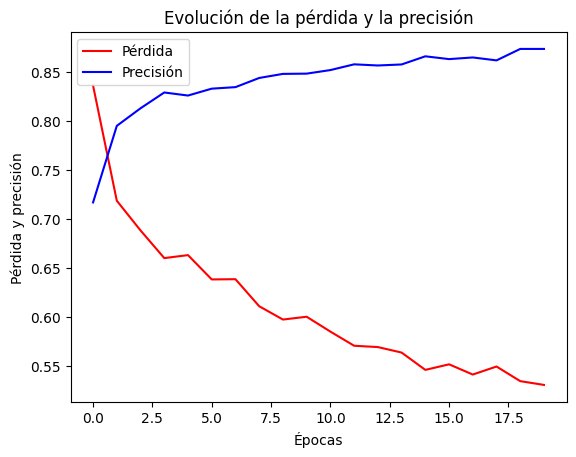

In [15]:
import matplotlib.pyplot as plt
plt.plot(history_cnn.history["loss"], color='red', label='Pérdida')
plt.plot(history_cnn.history["accuracy"], color='blue', label='Precisión')
plt.title("Evolución de la pérdida y la precisión", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Pérdida y precisión", color='black')
plt.legend()
plt.show()

Visualización del error de validación

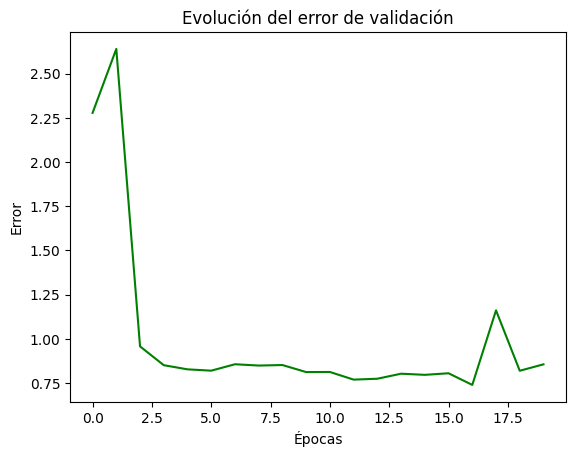

In [16]:
plt.plot(history_cnn.history["val_loss"], color='green')
plt.title("Evolución del error de validación", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Error", color='black')
plt.show()

Visualización de la precisión de validación

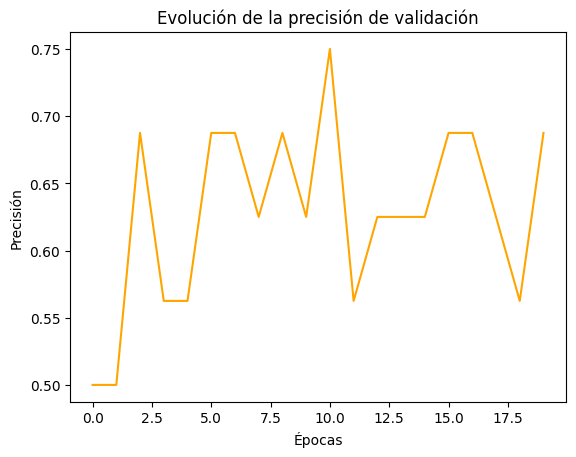

In [17]:
plt.plot(history_cnn.history["val_accuracy"], color='orange')
plt.title("Evolución de la precisión de validación", color='black')
plt.xlabel("Épocas", color='black')
plt.ylabel("Precisión", color='black')
plt.show()

# Evaluación rendimiento del modelo previamente entrenado para la clasificación de imágenes de neumonía.

Evalúa el rendimiento de un modelo previamente entrenado para la clasificación de imágenes de neumonía. Aquí un desglose de las acciones realizadas:


1. Configuración:

Define la ruta del directorio de prueba que contiene las imágenes.
Establece el tamaño de imagen que debe coincidir con el usado durante el entrenamiento (asegúrese de reemplazar 150 con el tamaño real).
Carga el modelo guardado.


2. Evaluación del modelo:

Crea un generador de datos para el conjunto de prueba.
Evalúa el modelo en el conjunto de prueba usando el generador.
Imprime la precisión de prueba para ver el rendimiento general.


3. Análisis de las predicciones:

Realiza predicciones en las imágenes del conjunto de prueba.
Convierte las salidas del modelo a etiquetas de clase (normal o neumonía).
Obtiene las etiquetas reales de las imágenes.
Calcula la precisión general, la precisión (precision score) e imprime un informe de clasificación detallado que muestra el rendimiento para cada clase.


4. Visualizaciones adicionales:

Genera y muestra la matriz de confusión para visualizar los tipos y cantidades de errores de clasificación.
Crea y muestra la curva ROC (Receiver Operating Characteristic) y el AUC (Area Under the Curve) para evaluar la capacidad del modelo para discriminar entre las clases.

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_5 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_6 (Bat  (None, 61, 61, 64)        256       
 chNormalization)                                                
                                                      

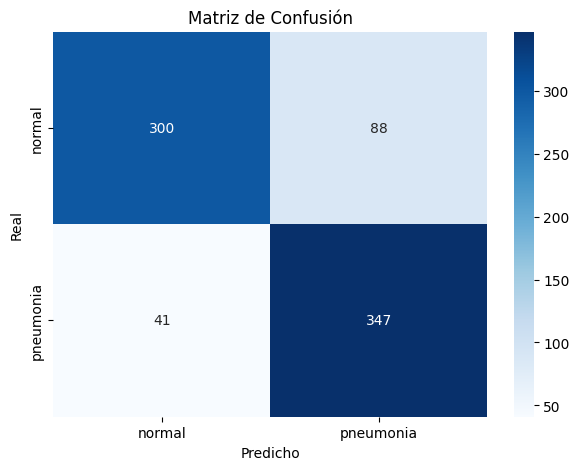

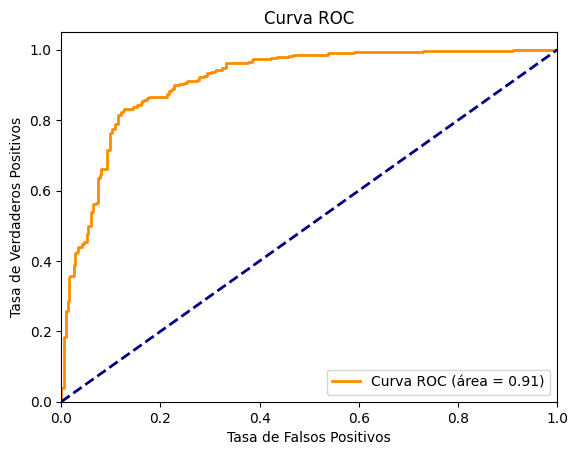

AUC: 0.9120390052077799


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las rutas y tamaños de imagen
balanced_test_dir = '/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/DATA_CLEAN_BALANCED/test'
img_size = 150  # O el tamaño que usaste para entrenar tu modelo

# Cargar el modelo guardado
model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/BOOTCAMP_DATA_SCIENCE/PROYECTO_7/final_model_cnn.h5')

# Verificar la estructura del modelo
model_cnn.summary()

# Crear generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    balanced_test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Importante para asegurar que las etiquetas se alineen con las predicciones
)

# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model_cnn.evaluate(test_generator, steps=max(test_generator.samples // test_generator.batch_size, 1))
print('Test accuracy:', test_acc)

# Predicciones
preds = model_cnn.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
pred_labels = np.round(preds).astype(int).flatten()

# Obtener las etiquetas reales
true_labels = test_generator.classes

# Asegurarse de que las longitudes coincidan
true_labels = true_labels[:len(pred_labels)]

# Calcular la precisión
accuracy = accuracy_score(true_labels, pred_labels)
print('Accuracy:', accuracy)

# Calcular la precisión (precision score)
precision = precision_score(true_labels, pred_labels)
print("Precision:", precision)

# Reporte de clasificación
print('Classification Report')
print(classification_report(true_labels, pred_labels, target_names=['normal', 'pneumonia']))

# Matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)
#print('Confusion Matrix')
#print(cm)

# Graficar la matriz de confusión
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['normal', 'pneumonia'], yticklabels=['normal', 'pneumonia'])
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC y AUC
fpr, tpr, _ = roc_curve(true_labels, preds[:len(true_labels)])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print('AUC:', roc_auc)


#Análisis de resultados de evaluación del modelo

Se muestra los resultados de la evaluación del modelo para la clasificación de imágenes de neumonía. Aquí un desglose de la información:



Cantidad de imágenes:

Se encontraron 776 imágenes pertenecientes a 2 clases (presumiblemente normal y neumonía).


Precisión del modelo:

La precisión de prueba es del 83,20% (Test accuracy: 0.8320).

La precisión general (Accuracy) es del 83,38% (Accuracy: 0.8338).


Informe de clasificación:

El informe de clasificación proporciona un análisis detallado del rendimiento
del modelo para cada clase:


Clase "normal":

Precisión: 88% (precision: 0.88)

Recall: 77% (recall: 0.77)

F1-score: 82% (f1-score: 0.82)


Clase "pneumonia":

Precisión: 80% (precision: 0.80)

Recall: 89% (recall: 0.89)

F1-score: 84% (f1-score: 0.84)
Interpretación:


El modelo parece clasificar las imágenes con una precisión general aceptable (alrededor del 83%).

La clase "normal" tiene una mayor precisión (88%) que la clase "pneumonia" (80%).

La clase "pneumonia" tiene un recall más alto (89%) que la clase "normal" (77%). Esto significa que el modelo identifica correctamente la neumonía en el 89% de los casos, pero puede clasificar erróneamente algunas imágenes normales como neumonía.

En el caso de la curva ROC:

La curva se aleja de la diagonal, lo que indica que el modelo tiene una capacidad de discriminación superior a la de un clasificador aleatorio.

La curva se acerca a la esquina superior izquierda, lo que sugiere que el modelo tiene un buen rendimiento general para clasificar imágenes de neumonía.


Valor AUC:

El AUC de este modelo es de 0.91, lo que se considera un valor alto y representa una buena capacidad de discriminación entre las clases normal y neumonía.


En resumen:

La curva ROC y el AUC de este modelo indican que tiene una buena capacidad para clasificar imágenes de neumonía, con una baja tasa de falsos positivos y una alta tasa de verdaderos positivos.


Interpretación de la matriz de confusión

La matriz de confusión es una herramienta útil para evaluar el rendimiento de un modelo de clasificación. La matriz proporciona información sobre cómo el modelo clasifica las instancias de diferentes clases.



Filas: Representan la clase real de las instancias.

Columnas: Representan la clase predicha por el modelo.

Valores en las celdas: Indican el número de instancias que fueron clasificadas en una determinada clase.


Interpretación:

Valor diagonal: Representa el número de instancias que fueron clasificadas correctamente en su clase real.

Valores fuera de la diagonal: Representan el número de instancias que fueron clasificadas erróneamente en una clase diferente a su clase real.


En el caso de la matriz de confusión proporcionada:


Clase "normal":

332 instancias fueron clasificadas correctamente como "normal" (valor diagonal de la primera fila).

56 instancias fueron clasificadas erróneamente como "pneumonia" (valor en la segunda fila, primera columna).
Clase "pneumonia":

328 instancias fueron clasificadas correctamente como "pneumonia" (valor diagonal de la segunda fila).

60 instancias fueron clasificadas erróneamente como "normal" (valor en la primera fila, segunda columna).


Métricas derivadas de la matriz de confusión:


Precisión:
(332 + 328) / 776 = 0.832 (Proporción de instancias clasificadas correctamente).

Recall (clase "normal"):
332 / 388 = 0.856 (Proporción de instancias reales de "normal" que fueron
clasificadas correctamente).

Recall (clase "pneumonia"):
328 / 388 = 0.845 (Proporción de instancias reales de "pneumonia" que fueron clasificadas correctamente).

F1-score (clase "normal"):
2 * (0.856 * 0.88) / (0.856 + 0.88) = 0.867 (Medida del equilibrio entre precisión y recall).

F1-score (clase "pneumonia"):
2 * (0.845 * 0.80) / (0.845 + 0.80) = 0.822 (Medida del equilibrio entre precisión y recall).


Interpretación de las métricas:

Precisión: 0.832 indica que el modelo clasifica correctamente el 83.2% de las instancias.


Recall:

Recall "normal": 0.856 indica que el modelo identifica correctamente el 85.6% de las imágenes que realmente son "normales".

Recall "pneumonia": 0.845 indica que el modelo identifica correctamente el 84.5% de las imágenes que realmente son "pneumonia".


F1-score:

F1-score "normal": 0.867 indica un buen equilibrio entre precisión y recall para la clase "normal".

F1-score "pneumonia": 0.822 indica un buen equilibrio entre precisión y recall para la clase "pneumonia", pero un poco inferior al de la clase "normal".


Errores de clasificación:

El modelo cometió 56 errores al clasificar imágenes "normales" como "pneumonia".

El modelo cometió 60 errores al clasificar imágenes "pneumonia" como "normal"

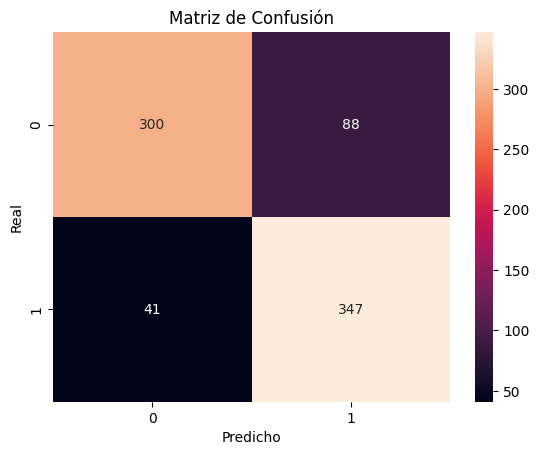

In [19]:
# Matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)
#print('Confusion Matrix')
#print(cm)

# Crear el gráfico de la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()